# Random Forest Forecast

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from pandas import DataFrame
import pickle

# Load and preprocess the data
df = pd.read_csv('lawas-rainfall-daily.csv', encoding='latin')

# df['Wind Speed'] = df['Wind Speed'].replace(np.nan, 0)
# df = df.fillna(method='ffill')

# Select features and target
data_input = df[['Rainfall (mm)', 'ANOM', 'Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']]

# Scaling the features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Function to create lagged features for all columns in the dataframe
def create_lagged_features(df, num_lags):
    df_lagged = DataFrame()
    for col in df.columns:
        for i in range(num_lags, 0, -1):
            df_lagged[f'{col}_t-{i}'] = df[col].shift(i)
    df_lagged['Current_Rainfall'] = df['Rainfall (mm)']
    df_lagged.dropna(inplace=True)
    return df_lagged

# Create lagged dataset for forecasting using all columns
num_lags = 60  # Number of lagged values to use for forecasting
df_lagged = create_lagged_features(data_input, num_lags)

# Separate features (lags of all columns) and target (Current_Rainfall)
features = df_lagged.drop(columns=['Current_Rainfall'])
target = df_lagged['Current_Rainfall']

# Scale features and target
features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.30, random_state=100, shuffle=False)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(x_train, y_train.ravel())


# with open("RF_model.pkl", 'wb') as file:  
#     pickle.dump(rf, file)

# with open('RF_model.pkl', 'rb') as f:
#     rf = pickle.load(f)

# Forecasting function
def forecast(model, initial_input, num_steps, feature_scaler, target_scaler):
    predictions = []
    current_input = initial_input

    for i in range(num_steps):
        current_input_scaled = feature_scaler.transform(current_input.reshape(1, -1))
        pred_scaled = model.predict(current_input_scaled)
        pred = target_scaler.inverse_transform(pred_scaled.reshape(-1, 1))
        predictions.append(pred[0][0])

        # Shift the input to include the new prediction as the latest 'lag'
        current_input = np.roll(current_input, -1)
        current_input[-1] = pred[0][0]

    return np.array(predictions)

# Forecast future values
forecast_length = 30  # For example, forecasting the next 30 days
initial_input = df_lagged.iloc[-1, :-1].values  # Take the last available data point as the starting input
predictions = forecast(rf, initial_input, forecast_length, feature_scaler, target_scaler)

# Output results
print(f"Predicted rainfall for the next {forecast_length} days:")
print(predictions)

# Plot forecasted values
plt.plot(predictions, label='Forecasted Rainfall', color='orange', alpha=0.6, linestyle='-', linewidth=2)
plt.xlabel('Day')
plt.ylabel('Rainfall (mm)')
plt.title(f'{forecast_length}-Day Forecast of Rainfall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_2976\3501730467.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{col}_t-{i}'] = df[col].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_2976\3501730467.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{col}_t-{i}'] = df[col].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_2976\3501730467.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X d

Predicted rainfall for the next 30 days:
[15.676  24.4975 25.67   31.911  23.5415 26.449  30.9075 29.2915 29.9415
 45.459  44.966  44.2305 32.542  40.184  44.7225 64.8335 70.6975 62.44
 60.4165 57.8455 63.3435 59.3655 62.3675 63.825  62.284  62.3515 63.264
 71.488  69.5425 68.3925]


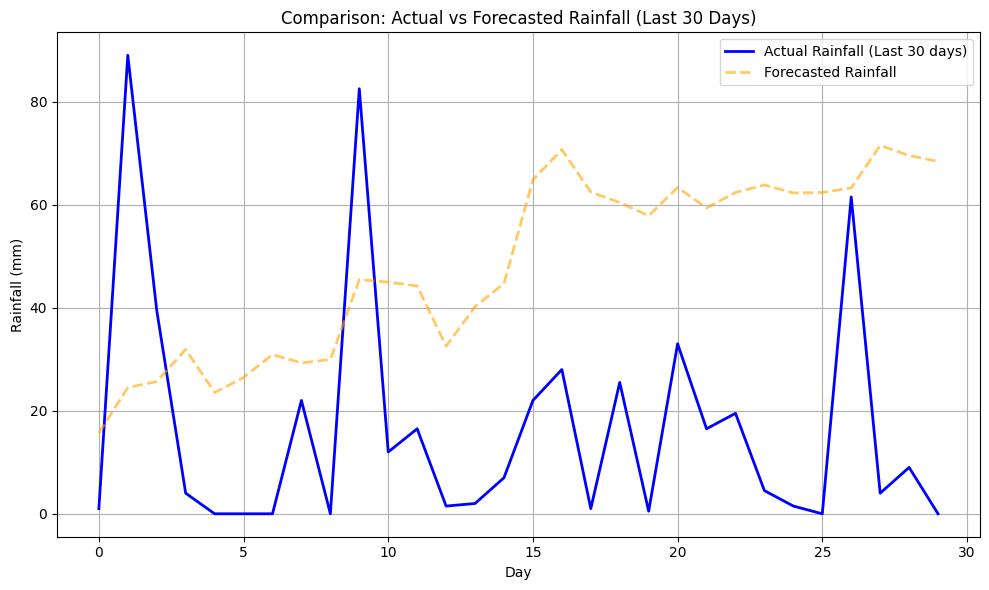

In [ ]:
# Forecast future values
forecast_length = 30  # For example, forecasting the next 30 days
initial_input = df_lagged.iloc[-30, :-1].values  # Take the last available data point as the starting input
predictions = forecast(rf, initial_input, forecast_length, feature_scaler, target_scaler)

# Get the actual rainfall data for the 30 days before the last observation
actual_rainfall_last_30_days = df_lagged['Current_Rainfall'].values[-30:]

# Output results
print(f"Predicted rainfall for the next {forecast_length} days:")
print(predictions)

# Plot forecasted vs actual values
plt.figure(figsize=(10, 6))

# Plot actual rainfall (30 days before the last observation)
plt.plot(range(forecast_length), actual_rainfall_last_30_days, label='Actual Rainfall (Last 30 days)', color='blue', linestyle='-', linewidth=2)

# Plot forecasted rainfall
plt.plot(range(forecast_length), predictions, label='Forecasted Rainfall', color='orange', alpha=0.6, linestyle='--', linewidth=2)

# Labels and title
plt.xlabel('Day')
plt.ylabel('Rainfall (mm)')
plt.title(f'Comparison: Actual vs Forecasted Rainfall (Last {forecast_length} Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Predict on the test set
y_pred_scaled = rf.predict(x_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()  # Convert predictions back to original scale
y_test_original = target_scaler.inverse_transform(y_test).ravel()  # Convert test targets back to original scale

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred)

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Evaluation Metrics:
Mean Absolute Error (MAE): 14.62
Mean Squared Error (MSE): 507.97
Root Mean Squared Error (RMSE): 22.54
R² Score: -0.09
